# IMPORTS

In [1]:
# all the relevant imports are done here
# run this if there are import errors: set DJANGO_SETTINGS_MODULE=ms2ldaviz.settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
basedir = 'C:\\Users\\rpetr\\OneDrive\\Desktop\\DISS_CODE\\ms2ldaviz\\ms2ldaviz'
sys.path.append(basedir)
import django
import json
django.setup()
from basicviz.models import Experiment, Alpha, Mass2MotifInstance, FeatureInstance, Feature, Document, Mass2Motif, DocumentMass2Motif, FeatureMass2MotifInstance
import numpy as np
import pylab as plt
import csv
from scipy.special import polygamma as pg
from scipy.special import psi as psi
import pickle 

MEDIA_ROOT is C:\Users\rpetr\OneDrive\Desktop\DISS_CODE\ms2ldaviz\ms2ldaviz\media


In [ ]:
SMALL_NUMBER = 1e-100

## IMPORT LDA DICT FILES

In [288]:
#load low threshold dict
file = open('mb_lower_thresh.dict','r')
lda_dict_low_thresh = pickle.load(file)

In [10]:
#load high threshold dict
file = open('mb_normal_thresh.dict','r')
lda_dict_high_thresh = pickle.load(file)

In [289]:
#choose dict you are interested in
lda_dict=lda_dict_low_thresh

In [256]:
#choose the keys you are most interested in 
lda_dict.keys()

['phi',
 'features',
 'doc_metadata',
 'alpha',
 'K',
 'word_index',
 'topic_index',
 'beta',
 'topic_metadata',
 'theta',
 'corpus',
 'overlap_scores',
 'doc_index',
 'gamma']

## GET CORPUS DOCUMENT

In [290]:
#get all the docs in the corpus of input file
doc_list=lda_dict['corpus'].keys()

In [291]:
#get the document id for the document chosen (CHANGED MANUALLY)
chosen_document=[269485]

In [292]:
#name to db_id document dictionary
docs = Document.objects.filter(id__in=chosen_document)
docdbid2name = {}
for d in docs:
    docdbid2name.update({int(d.id):d.name})

In [293]:
#unique documents is the dictionary -> doc: id (THIS IS REDUNDANT TO BE DELETED)
unique_docs = {}
index = 0 
for doc in docdbid2name.values(): 
    unique_docs.update({doc:index})
    index+=1

In [294]:
# map documents to indices
unique_docs=lda_dict['doc_index']

In [295]:
# get your unique document 
unique_doc = unique_docs[docdbid2name[chosen_document[0]]]
unique_doc

170

## GET CORPUS WORDS

In [296]:
# get all words for the imported experiment 
all_words = []
for doc in lda_dict['corpus']:
    for word in lda_dict['corpus'][doc]:
        all_words.append(word)
all_words=set(all_words)
all_words=list(all_words)

In [297]:
# unique words lists all the features as {feature_id:incremental_id} word value pairs. (REDUNDANT TO BE DELETED)
unique_words = {}
index = 0
for word in all_words:
    if word not in unique_words.keys():
        unique_words.update({word:index})
        index+=1

In [298]:
# map words to indices
unique_words=lda_dict['word_index']

In [299]:
# get all the words for the specific document 
word_list = lda_dict['corpus'][docdbid2name[chosen_document[0]]].keys()

## GET CORPUS TOPICS

In [300]:
# map topic to index
unique_topics = lda_dict['topic_index']

## GET ALPHA

In [301]:
alpha_vector = np.array(lda_dict['alpha'])

## GET BETA

In [302]:
#Get all beta values.
beta_prep_list = []
for topic in lda_dict['beta']: 
    for word in lda_dict['beta'][topic]:
        beta_prep_list.append([unique_topics[topic],unique_words[word],lda_dict['beta'][topic][word]])

In [303]:
#Populate beta matrix.
K = len(unique_topics)
W = len(unique_words)
pivot_table = np.zeros((K, W)).astype('float')
i = 0
max = len(beta_prep_list)
while i<max:
    pivot_table[int(beta_prep_list[i][0]),int(beta_prep_list[i][1])]=beta_prep_list[i][2]
    i+=1

In [304]:
#Create a normalised beta matrix. 
pivot_table_normalised = pivot_table
i = 0
while i<K: 
    row = pivot_table_normalised[i, :]
    adjusted_row = row + SMALL_NUMBER
    normalised_row = adjusted_row / np.sum(adjusted_row)
    np.sum(normalised_row)
    pivot_table_normalised[i, :] = normalised_row
    i+=1

## GET ORIGINAL GAMMA

In [307]:
gamma_vector_original = np.copy(lda_dict['gamma'])

In [308]:
gamma_vector_original 

array([2.27671599e-04, 2.89315100e-03, 3.46631069e-04, 1.92616546e-04,
       3.05104197e-04, 1.92605535e-04, 1.13096295e-03, 3.27569125e-03,
       3.62517303e-03, 3.05037980e-04, 1.17791654e-03, 2.65638491e-04,
       3.05859502e-04, 2.66538929e-04, 3.90249670e-04, 1.92766043e-04,
       5.69013280e-04, 4.57484312e-03, 2.68420279e-04, 1.92636672e-04,
       1.22331451e-03, 2.27828834e-04, 2.27661075e-04, 1.86084281e+03,
       2.65210099e-04, 2.65248243e-04, 3.89368699e-04, 1.64943886e-03,
       9.43324637e-04, 1.92919902e-04, 1.95665683e-04, 4.22803699e-03,
       2.66973312e-04, 1.09315767e-02, 4.32671511e-04, 2.29328643e-04,
       3.49571452e-04, 1.93589244e-04, 1.78710098e-04, 3.89036124e-04,
       1.60722275e-04, 2.80212556e-03, 1.93699325e-04, 5.24969887e-04,
       9.43757954e-04, 1.60539088e-04, 1.69858641e-03, 3.05283484e-04,
       6.60914599e-04, 3.17944823e-03, 6.61117637e-04, 1.41560242e-03,
       1.60456969e-04, 2.41809252e-03, 8.02136659e-04, 7.08275139e-04,
      

## GET ORIGINAL PHI

In [309]:
# get original phi - it is initially in the form of doc, word, topic, probability
phi_dict = lda_dict['phi']

## INITIALISE CORPUS BEFORE E-STEP (1 document only)

In [310]:
#create corpus dict list first 
corpus_dict_list = []
temp_dict = lda_dict['corpus'][docdbid2name[chosen_document[0]]]
for word in temp_dict:
    corpus_dict_list.append([int(unique_doc), int(unique_words[word]),int(temp_dict[word])])

In [311]:
#create corpus_dict for e-step => doc_id:{word_id:intensity}
corpus_dict={}
temp_dict={}
for line in corpus_dict_list:
    temp_dict.update({line[1]:line[2]})
corpus_dict.update({corpus_dict_list[0][0]:temp_dict})

# E-STEP (has 9 steps)

## Step 0 - E-step variables

In [312]:
# alpha_vector is already mentioned above
# beta_matrix is created here from pivot_table_normalised
# K and W are from above for total unique topics, total unique words respectively 
# you need a corpus (created above)
corpus = corpus_dict
beta_matrix = pivot_table_normalised

## Step 1 - Initialise phi matrix

In [313]:
# initialise the 3D matrix phi with zeroes
phi_matrix={}
for doc in corpus: 
    d = int(doc)
    phi_matrix[d] = {}
    for word in corpus[doc]:
        w = int(word)
        phi_matrix[d][w]=np.zeros(K)

## Step 2 - initialise gamma matrix

In [314]:
# create a gamma matrix with rows as documents and columns as topics 
# this will later be transposed in order to create the phi matrix in the steps 3-9 below
# doc_total is the count of words per doc, and each gamma is alpha plus that

gamma_matrix=np.zeros((int(len(corpus)),int(K))) #3x500 shape
for doc in corpus:
    doc_total=0.0
    for word in corpus[doc]:
        doc_total += corpus[doc][word]
    gamma_matrix[0,:] = alpha_vector + 1.0*(doc_total/K)

## Step 3 - 9: repeat until convergence loop

In [315]:
# initialise phi and do Blei's loop, 1000 iterations usually suffice (Simon's implementation) 
test_list = []
iterations=1000
n_words = int(len(unique_words))
temp_beta = np.zeros((K, n_words))
current_gamma = np.copy(gamma_matrix)
for i in range(iterations):   
    prev_gamma = np.copy(current_gamma)
    for doc in corpus:
        d = int(doc)
        doc_dict = corpus[doc]
        temp_gamma = np.zeros(K) + alpha_vector
        for word in doc_dict:  
            w = int(word)
            log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[0,:]).T #changed here for 1 doc prototype
            log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
            phi_matrix[d][w] = log_phi_matrix/log_phi_matrix.sum()
            temp_gamma += phi_matrix[d][w]*corpus[doc][word]
            temp_beta[:,w] += phi_matrix[d][w] * corpus[doc][word]
        gamma_matrix[0,:] = temp_gamma #changed here for 1 doc prototype
        pos = np.where(gamma_matrix[0,:]<SMALL_NUMBER)[0] #changed here for 1 doc prototype
        gamma_matrix[0,pos] = SMALL_NUMBER #changed here for 1 doc prototype
    current_gamma = np.copy(gamma_matrix)
    gamma_diff = ((current_gamma - prev_gamma)**2).sum()
#     beta_matrix = temp_beta
    test_list.append([i, gamma_diff])

In [317]:
# test the output list of the above e-step 
test_list[310:320]

[[310, 3.3302769042306706e-14],
 [311, 2.9755055773484925e-14],
 [312, 2.655746091466392e-14],
 [313, 2.3719277845119517e-14],
 [314, 2.1191239495092263e-14],
 [315, 1.8916680961277312e-14],
 [316, 1.6911703281990006e-14],
 [317, 1.5095286886801006e-14],
 [318, 1.3494553259814181e-14],
 [319, 1.2037736405309629e-14]]

In [247]:
# get an array output if necessary 
gamma_diff_array = np.array(test_list)
np.savetxt("gamma_diff_array.csv", gamma_diff_array, delimiter=",", fmt="%s")

# COMPARISON OF GAMMA & PHI (original vs calculated csv exports) 

## Gamma comparison / actually Theta comparison 

In [32]:
# output_data_theta is the original data we work with, which is an 3 column matrix (doc_id, topic_id, probability)
# we aim to transform output_data_theta into a normalised vector 
# note that this implementation only works for a single document 
gamma_vector_original = np.zeros(K) 
for line in range(len(output_data_theta)):
    pos = int(output_data_theta[line][1])
    prob = output_data_theta[line][2]
    gamma_vector_original[pos] = prob

In [321]:
gamma_vector_original /= np.sum(gamma_vector_original)

In [322]:
# normalise calculated gamma vector
gamma_vector_calculated = np.zeros(K) 
gamma_vector_calculated = np.copy(gamma_matrix[0])
gamma_vector_calculated /= np.sum(gamma_vector_calculated)

In [323]:
# export for comparison if needed
np.savetxt("compare_gamma1.csv", gamma_vector_original, delimiter=",", fmt="%s")
np.savetxt("compare_gamma2.csv", gamma_vector_calculated, delimiter=",", fmt="%s")

In [287]:
gamma_original_calculated.max()

NameError: name 'gamma_original_calculated' is not defined

In [38]:
#get a list of topics from original gamma/theta
topics_tested = np.array(output_data_theta)[:,1]
temp = []  
for t in topics_tested: 
    temp.append(int(t))
topics_tested = temp

In [ ]:
gamma_diff_array = []
for t in topics_tested: 
    gamma_diff_array.append([])
    

## Phi comparison (for words above min "noise" intensity)

In [40]:
#Get the words from de corpus dict that have the highest intensity. 
material_words = []
for doc in corpus_dict: 
    for word in corpus_dict[doc]:
        w = corpus_dict[doc][word]
        if int(w) > 20:
            material_words.append([int(word), w]) 

In [41]:
material_words_dict = {}
for line in material_words:
    material_words_dict.update({line[0] : line[1]})

In [42]:
#Make a numpy array. 
material_words_array = np.array(material_words)

In [43]:
#Sort the array descending order. 
material_words_array = material_words_array[(-material_words_array)[:,1].argsort()]

In [44]:
#Choose material words for comparison loop.
material_words_list = list(material_words_array[:,0])

In [45]:
len(material_words_list)

46

In [46]:
phi_comparison = []
for line in phi_list: 
    line_word = int(line[2])
    if line_word in material_words_list:
        line_doc = unique_docs[line[0]]
        line_topic = int(line[1])
        line_original_prob = line[3]
        line_prob = phi_matrix[line_doc][line_word][line_topic]
        phi_diff = abs(line_original_prob-line_prob)
        intensity = material_words_dict[line_word]
        phi_comparison.append([line_doc, line_word, line_topic, line_original_prob, line_prob, phi_diff, intensity])

In [47]:
len(phi_comparison)

51

In [48]:
phi_comparison_array = np.array(phi_comparison)

In [49]:
max_phi_diff = list(phi_comparison_array[:,5])
max_phi_diff = [float(i) for i in max_phi_diff]
max_phi_diff.sort()
max_phi_diff = max_phi_diff[-1]
max_phi_diff

0.32217156271421166

In [50]:
phi_comparison_array[:,5:]

array([[3.47189009e-05, 1.00000000e+03],
       [1.06976759e-04, 1.97000000e+02],
       [1.09728477e-01, 2.10000000e+01],
       [7.15651090e-03, 2.40000000e+01],
       [9.53491275e-02, 2.20000000e+01],
       [6.59614044e-02, 2.20000000e+01],
       [2.23457714e-02, 5.50000000e+01],
       [3.98754744e-02, 2.20000000e+01],
       [1.81382041e-01, 2.80000000e+01],
       [1.49122591e-02, 2.40000000e+01],
       [2.39852564e-02, 1.31000000e+02],
       [9.64630166e-03, 2.97000000e+02],
       [2.78306677e-01, 3.70000000e+01],
       [1.16137013e-01, 4.60000000e+01],
       [1.85349487e-02, 2.40000000e+01],
       [4.09072398e-02, 4.83000000e+02],
       [3.48140729e-04, 7.60000000e+01],
       [6.25323953e-02, 2.20000000e+01],
       [1.44772802e-02, 1.31000000e+02],
       [4.18488369e-04, 7.60000000e+01],
       [1.50189519e-03, 2.10000000e+01],
       [2.37402298e-05, 4.83000000e+02],
       [2.48331356e-02, 3.60000000e+01],
       [5.05633179e-02, 2.40000000e+01],
       [5.231837

In [51]:
phi_comparison_intenphi = np.copy(phi_comparison_array[:,5:])

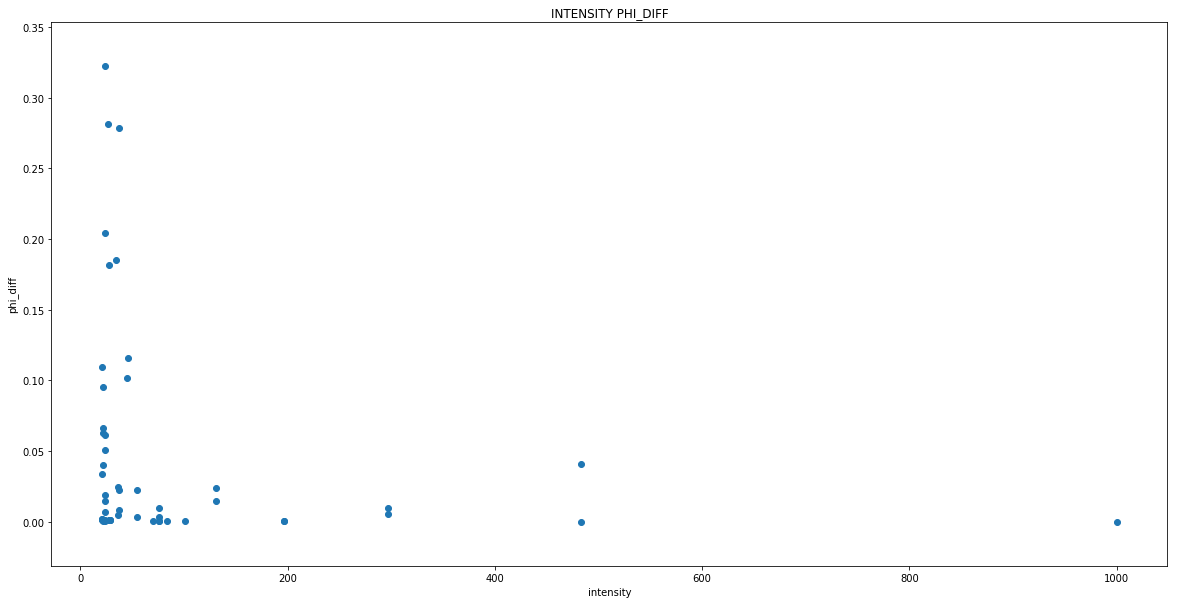

In [52]:
# Plot word intensity on x axis and phi difference on y axis on a scatterplot. 
x = phi_comparison_intenphi[:,1]
y = phi_comparison_intenphi[:,0]
fig = plt.figure()
scatterplot = fig.add_subplot(1,1,1)
plt.scatter(x,y)
fig.set_size_inches(20,10)
plt.title("INTENSITY PHI_DIFF")
plt.xlabel("intensity")
plt.ylabel("phi_diff")
plt.show()

## Theta Comparison (Gamma Comparison) 

In [ ]:
original_

In [ ]:
phi_original

In [54]:
topics_tested = np.array(output_data_theta)[:,1]
temp =[]  
for t in topics_tested: 
    temp.append(int(t))
topics_tested = temp
print("topic", "material", "immaterial")
for topic in topics_tested: 
    topic_tested = topic
    count_material = 0
    count_immaterial = 0
    for line in phi_original: 
        if line[2] == topic_tested:
            if line[1] not in material_words_list:
                count_immaterial += 1
            else:
                count_material += 1
    print(topic_tested, count_material, count_immaterial)

('topic', 'material', 'immaterial')
(56, 41, 747)
(224, 2, 1)
(471, 1, 0)
(413, 1, 0)
(468, 1, 0)


In [ ]:
print(385+431)
len(corpus_dict['0'])
